In [1]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Charger les chemins et labels
df = pd.read_csv("C:/Users/user/Desktop/images/labels.csv")

# Encoder les labels (texte → int)
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Diviser en train/test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'], random_state=42)


Label: severe pain
Image path: C:\Users\user\Desktop\images\severe pain\023_jpg.rf.a23e24b2f4004199d2e32122f77c3a18_gen_4.png


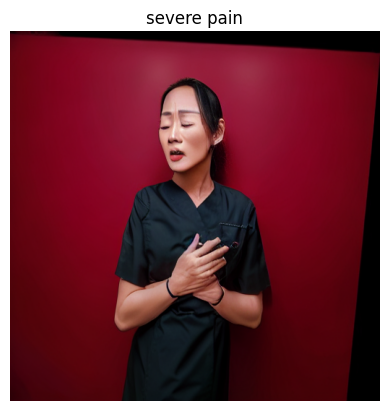

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

# Choisir une ligne au hasard
sample = df.sample(1000).iloc[0]

# Afficher les infos
print(f"Label: {sample['label']}")
print(f"Image path: {sample['image_path']}")  # Ne pas ajouter "images/"

# Charger et afficher l'image
image = Image.open(sample['image_path'])  # Utiliser directement le chemin
plt.imshow(image)
plt.axis('off')
plt.title(sample['label'])
plt.show()


In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

# Télécharger le feature extractor (pré-traitement des images pour ViT)
extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(le.classes_),  #  nombre de classes
    id2label={i: label for i, label in enumerate(le.classes_)},
    label2id={label: i for i, label in enumerate(le.classes_)},
    ignore_mismatched_sizes=True 
)


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should pr

In [4]:
for param in model.parameters():
    param.requires_grad = True

In [5]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np

In [6]:

class PainDataset(Dataset):
    def __init__(self, df, extractor, root_dir):
        self.df = df
        self.extractor = extractor
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.root_dir, row['image_path'])
        image = Image.open(image_path).convert("RGB")
        inputs = self.extractor(images=image, return_tensors="pt")
        item = {k: v.squeeze() for k, v in inputs.items()}
        item["labels"] = torch.tensor(row["label_encoded"])
        return item



In [7]:
# Préparer les datasets
train_dataset = PainDataset(train_df, extractor, "images")
test_dataset = PainDataset(test_df, extractor, "images")

In [ ]:
# from torch.nn import CrossEntropyLoss

# # Pondération des classes
# labels = train_df['label_encoded'].values
# class_counts = np.bincount(labels)
# class_weights = 1. / class_counts
# weights = torch.FloatTensor(class_weights)

# # Loss pondérée
# loss_fn = CrossEntropyLoss(weight=weights)

In [8]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./vit-pain-output",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    do_eval=True,
    do_train=True
)

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss()  
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [13]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=extractor,
)


C:\Users\user\AppData\Local\Temp\ipykernel_3496\2111063075.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [14]:
trainer.train()

Step,Training Loss
100,0.871800
200,0.321700
300,0.168900
400,0.074000
500,0.046000


TrainOutput(global_step=575, training_loss=0.2605833708721658, metrics={'train_runtime': 4022.019, 'train_samples_per_second': 1.136, 'train_steps_per_second': 0.143, 'total_flos': 3.541447405994803e+17, 'train_loss': 0.2605833708721658, 'epoch': 5.0})

In [15]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Évaluation brute
metrics = trainer.evaluate()
print("Évaluation brute du modèle (perte sur test) :", metrics)

# Prédictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Accuracy
acc = accuracy_score(labels, preds)
print(f"\nAccuracy: {acc:.4f}")

# F1-score (macro)
f1 = f1_score(labels, preds, average='macro')
print(f"F1-score (macro): {f1:.4f}")

# Rapport complet
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=le.classes_))

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Évaluation brute du modèle (perte sur test) : {'eval_loss': 0.40536606311798096, 'eval_runtime': 72.7239, 'eval_samples_per_second': 3.149, 'eval_steps_per_second': 0.399, 'epoch': 5.0}

Accuracy: 0.8646
F1-score (macro): 0.8506

Classification Report:
               precision    recall  f1-score   support

moderate pain       0.84      0.66      0.74        32
      no pain       0.90      0.95      0.92        55
  severe pain       0.95      0.83      0.88        46
    soft pain       0.82      0.91      0.86        96

     accuracy                           0.86       229
    macro avg       0.88      0.83      0.85       229
 weighted avg       0.87      0.86      0.86       229



In [22]:
import cv2
from PIL import Image
import torch
import numpy as np

def predict_face_from_camera(model, extractor, label_encoder):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    cap = None
    try:
        cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)  # <- Utilise DirectShow (Windows)

        if not cap.isOpened():
            print("Erreur : Impossible d’ouvrir la webcam.")
            return

        print("Appuie sur 'q' pour quitter.")

        while True:
            ret, frame = cap.read()
            if not ret:
                print("Erreur de lecture caméra.")
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

            for (x, y, w, h) in faces:
                face_img = frame[y:y+h, x:x+w]
                face_pil = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))

                inputs = extractor(images=face_pil, return_tensors="pt").to(device)
                with torch.no_grad():
                    outputs = model(**inputs)
                    logits = outputs.logits
                    pred_id = logits.argmax(-1).item()
                    pred_label = label_encoder.inverse_transform([pred_id])[0]

                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(frame, pred_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.9, (36,255,12), 2)

            cv2.imshow('Webcam - Prédiction douleur', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    except Exception as e:
        print(f"Erreur rencontrée : {e}")
    finally:
        if cap:
            cap.release()
        cv2.destroyAllWindows()
        print("Caméra libérée et fenêtres fermées.")


In [29]:
predict_face_from_camera(model, extractor, le)


Appuie sur 'q' pour quitter.
Caméra libérée et fenêtres fermées.
